---

<div style="text-align: center;">
    <h1>Proyecto de Aprendizaje por Refuerzo</h1>
    <h2>Taxi-v3: El problema del taxi - OpenAI Gym </h2>
    <h3>Master de Inteligencia Artificial</h3>
    <h4>Guillem Miralles Gadea</h4>
    <h4>Fecha de Entrega: 25 de Junio de 2023</h4>
</div>

---

# 1. Introducción:

En este trabajo, nos adentramos en el problema del Taxi en el entorno de OpenAI Gym mediante Aprendizaje por Refuerzo.

### Descripción del problema

El problema del Taxi plantea un escenario en el que un taxista virtual debe navegar por una ciudad en busca de pasajeros y llevarlos a sus destinos correspondientes de manera eficiente. En este entorno complejo y dinámico, el taxista se enfrenta a desafíos tales como la planificación de rutas, la toma de decisiones óptimas y la optimización de la utilización del tiempo, todo ello mientras cumple con las restricciones del tráfico y las demandas de los pasajeros.

Este problema presenta características únicas que lo distinguen de otros entornos de RL. Por un lado, el taxista debe considerar la ubicación actual del pasajero, así como también las restricciones espaciales y la disponibilidad de destinos posibles para realizar recogidas y entregas. Además, las acciones tomadas por el taxista pueden tener un impacto directo en la calidad del servicio y la satisfacción del pasajero, lo que añade una dimensión adicional de optimización a la tarea.

### Objetivos del trabajo

El objetivo principal de este trabajo es aplicar y evaluar un enfoque de RL para abordar el desafiante problema del Taxi en el entorno de OpenAI Gym. Buscamos entrenar un agente de RL capaz de aprender una política óptima que maximice la eficiencia en la recogida y entrega de pasajeros, minimizando el tiempo de viaje y optimizando las rutas utilizadas.

Para alcanzar estos objetivos, emplearemos el algoritmo de Q-Learning, una técnica de RL ampliamente utilizada y conocida por su capacidad para aprender políticas óptimas en entornos discretos.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
from IPython.display import clear_output
import time
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from hyperopt import hp, fmin, tpe, Trials, space_eval
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# 2. OpenAI Gym y el entorno Taxi-v3

Taxi v3: https://www.gymlibrary.dev/environments/toy_text/taxi/

## Descripción del entorno
El entorno Taxi-v3 simula un problema en el que un taxi debe recoger y dejar pasajeros en diferentes ubicaciones dentro de una ciudad. La ciudad se representa como una cuadrícula de 5x5, con casillas en las que se encuentran el taxi, los pasajeros y las ubicaciones de recogida y entrega. El objetivo del taxi es recoger a un pasajero en una ubicación de recogida y dejarlo en su destino correspondiente.

## Estado
Hay 500 estados discretos, el estado del entorno Taxi-v3 se representa como una matriz de 500 posibles estados. Cada estado tiene en cuenta la ubicación del taxi (una de las 25 casillas), la ubicación del pasajero (una de las 5 casillas), la ubicación de recogida (una de las 4 casillas restantes) y la ubicación de entrega (una de las 4 casillas restantes). El estado también tiene en cuenta si el pasajero está dentro del taxi o si ya ha sido entregado.

Localización de pasajeros:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

Destinaciones:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

Cada espacio de estados está representado por la tupla: (fila_taxi, taxi_col, ubicación_pasajero, destino)


## Acciones
El taxi puede tomar 6 acciones posibles: moverse hacia arriba, moverse hacia abajo, moverse hacia la izquierda, moverse hacia la derecha, recoger un pasajero y dejar un pasajero. Estas acciones permiten al taxi moverse por la cuadrícula para recoger y entregar pasajeros en las ubicaciones correspondientes.

- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

## Recompensas
El sistema de recompensas en este problema está diseñado de la siguiente manera:

- El taxi recibe una recompensa de -1 por cada paso que toma. Esta es una recompensa negativa que incentiva al taxi a completar su tarea (recoger y dejar al pasajero) lo más rápido posible.

- Existe una penalización de -10 si el taxi intenta recoger o dejar a un pasajero en una ubicación incorrecta. Esta penalización es significativamente mayor que el costo por paso, reflejando la importancia de ejecutar las acciones correctas en las ubicaciones correctas.

- Al entregar al pasajero a su destino, el taxi recibe una recompensa de +20. Esta recompensa positiva grande sirve para incentivar al agente a llevar a cabo su tarea principal con éxito.

### Recompensa esperada:
Un agente puede lograr una recompensa promedio de alrededor de 4-12 por episodio. Esto se traduce en que el agente puede, en promedio, completar la tarea en alrededor de 8 a 16 pasos.

# 3. Q-Learning

Dado que el problema del Taxi es un problema de tamaño pequeño y totalmente observable, vamos a provar con el algoritmo de Q-Learning para encontrar la política óptima.

### Código diseñado:

Para resolver el problema, implementa el algoritmo de Q-learning, que es una técnica de aprendizaje por refuerzo que se utiliza para encontrar una política óptima en un entorno de decisión de Markov (MDP).El núcleo de Q-learning es la tabla Q, que es una tabla que registra la "calidad" esperada de cada acción en cada estado.

El código también hace uso de una estrategia de búsqueda de hiperparámetros, utilizando la biblioteca Hyperopt. Define un espacio de búsqueda para varios parámetros importantes del algoritmo Q-learning, como la tasa de aprendizaje (alpha), la tasa de descuento (gamma), y el factor de exploración (epsilon_start, epsilon_decay, epsilon_cut). Luego, utiliza la búsqueda bayesiana de Hyperopt para encontrar la mejor combinación de estos parámetros que minimiza la función objetivo. La función objetivo se define como la recompensa media obtenida por el agente en cada episodio. Como estamos minimizando la función objetivo, pero en realidad queremos maximizar la recompensa, tomamos el negativo de la recompensa media.

En cada paso, Hyperopt elige un nuevo conjunto de hiperparámetros para probar en base a los resultados de las pruebas anteriores. De esta manera, la búsqueda se realiza de manera inteligente, dedicando más tiempo a las regiones del espacio de hiperparámetros que parecen más prometedoras.

Creo que podemos encontrar, en este apartado, una solución bastante buena ya que, la utilización de la estrategia ε-greedy permite un buen equilibrio entre la explotación de lo que el agente ya sabe y la exploración de nuevas acciones y la búsqueda de hiperparámetros asegura que estamos utilizando una buena combinación de parámetros para nuestro algoritmo Q-learning.

In [24]:
# Creamos el ambiente Taxi
env = gym.make("Taxi-v3")

# Número de estados y acciones
state_space = env.observation_space.n
action_space = env.action_space.n

# Definimos el espacio de búsqueda
space = [hp.uniform('alpha', 0, 0.3),
         hp.uniform('epsilon_start', 0.5, 1),
         hp.uniform('epsilon_decay', 0.8, 0.9999),
         hp.choice('epsilon_cut', [
             ('epsilon_cut_none', None),
             ('epsilon_cut', hp.uniform('epsilon_cut_value', 0, 0.3))
         ]),
         hp.uniform('gamma', 0.3, 1)]

# Definimois la función objetivo
def objective(params):
    alpha, epsilon_start, epsilon_decay, epsilon_cut, gamma = params

    # Inicializamos la tabla Q
    q_table = np.zeros((state_space, action_space))

    # Almacenamos las recompensas totales de cada episodio
    rewards = []

    # Entrenamos el agente
    for i in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Seleccionamos de acción basada en la política ε-greedy
            if random.uniform(0, 1) < epsilon_start:
                # Explorar acción del espacio
                action = env.action_space.sample()
            else:
                # Explotamos acción aprendida
                action = np.argmax(q_table[state])

            next_state, reward, done, info = env.step(action)
            # Suma la recompensa a la recompensa total
            episode_reward += reward

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Actualizamos la tabla Q
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state
        # Recompensa total dEel episodio
        rewards.append(episode_reward)
    return -np.mean(rewards)

# Optimización de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)
print('Best params')
print(space_eval(space, best))


100%|██████████| 100/100 [54:17<00:00, 32.57s/trial, best loss: 59.6994]
Best params
(0.2848271627893171, 0.5001040626877423, 0.9216658605860514, ('epsilon_cut_none', None), 0.7011151355263485)


Los hiperparametros encontrados anteriormente son:
- alpha = 0.2848271627893171
- gamma = 0.7011151355263485
- epsilon_start = 0.5001040626877423
- epsilon_decay = 0.9216658605860514
- epsilon_cut = None
- episodes = 10000

Ahora, vamos a ver como se entrena el agente con estos parametros.

In [ ]:
# Crea el ambiente Taxi
env = gym.make("Taxi-v3")

# Número de estados y acciones
state_space = env.observation_space.n
action_space = env.action_space.n

# Inicializa la tabla Q
q_table = np.zeros((state_space, action_space))

# Hiperparámetros
alpha = 0.2848271627893171
gamma = 0.7011151355263485
epsilon_start = 0.5001040626877423
epsilon_decay = 0.9216658605860514
epsilon_cut = None
episodes = 10000

# Almacena las recompensas totales de cada episodio
rewards = []

# Crea un VideoRecorder
recorder = VideoRecorder(env, path='/content/gdrive/MyDrive/video.mp4')

# Entrena el agente
for i in range(episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    # Revisa si epsilon_cut es None antes de compararlo
    epsilon = epsilon_start * (epsilon_decay ** i) if epsilon_cut is None else max(epsilon_start * (epsilon_decay ** i), epsilon_cut)

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_state, reward, done, info = env.step(action)
        episode_reward += reward

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        state = next_state

        # Graba el ambiente
        recorder.capture_frame()

    rewards.append(episode_reward)

recorder.close()

np.save("q_table.npy", q_table)
np.save("rewards_q.npy", rewards)


# 4. Resultados:

En esta sección, nos sumergiremos en los resultados derivados del entrenamiento de nuestro agente. Para facilitar la visualización de estos resultados, vamos a ver un gráfico que muestre cómo cambió la recompensa total a lo largo de los episodios. Este gráfico nos ayudará a entender mejor el ritmo y la eficacia del proceso de aprendizaje de nuestro agente.



### Recompensas obtenidas por episodio durante el entrenamiento de Q-Learning

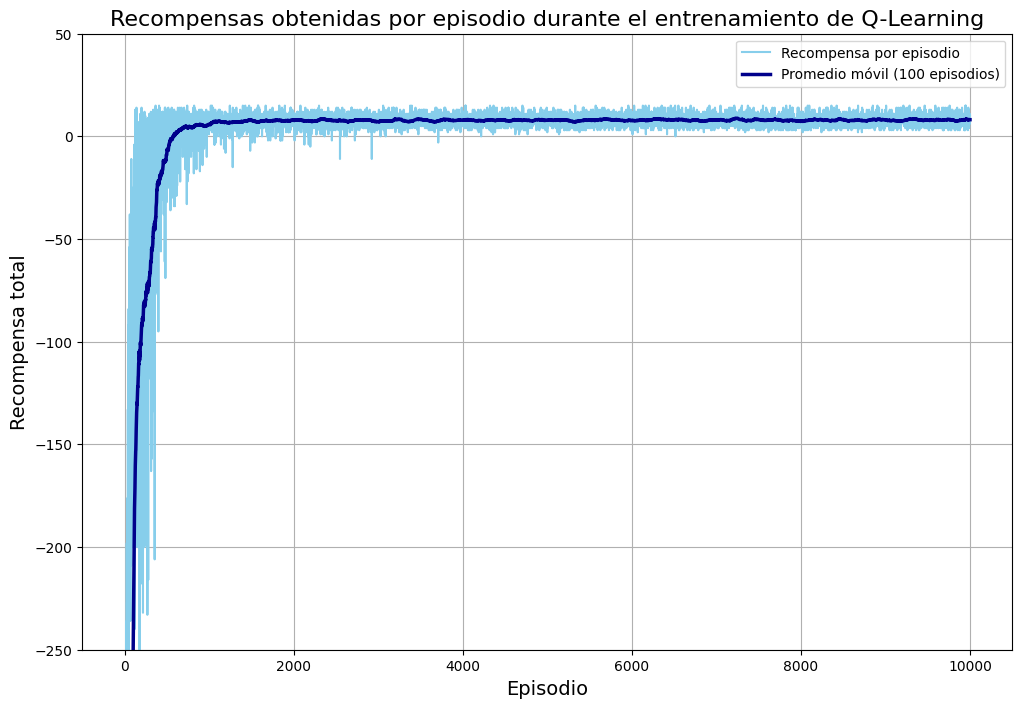

In [36]:
# Carga los resultados
q_table = np.load("q_table.npy")
rewards = np.load("rewards_q.npy")

# Crea un promedio móvil de las recompensas para suavizar el gráfico
window_size = 100  # Puedes ajustar este valor
smoothed_rewards = [np.mean(rewards[max(0, i-window_size):(i+1)]) for i in range(len(rewards))]

# Crea un gráfico de las recompensas totales de cada episodio
plt.figure(figsize=(12, 8))
plt.plot(rewards, label='Recompensa por episodio', color='skyblue')
plt.plot(smoothed_rewards, label='Promedio móvil ({} episodios)'.format(window_size), color='darkblue', linewidth=2.5)
plt.title("Recompensas obtenidas por episodio durante el entrenamiento de Q-Learning", fontsize=16)
plt.xlabel("Episodio", fontsize=14)
plt.ylabel("Recompensa total", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


En el gráfico anterior, es posible observar la evolución del rendimiento del agente a lo largo del tiempo.

Las recompensas iniciales son predominantemente negativas y bastante altas en magnitud. Esto sugiere que el agente está en las etapas iniciales de aprendizaje, donde está explorando el entorno y a menudo toma decisiones que no conducen a recompensas inmediatas.

A partir de los 1000 episodios, disminuyen significativamente las recompensas negativas. Esto indica que el agente ha aprendido de los errores iniciales y está tomando decisiones que resultan en mejores recompensas. Seguidamente, hay algunos valores negativos dispersos, pero estos son cada vez menos frecuentes, lo que indica que el agente está cometiendo menos errores a medida que pasa el tiempo.

Sobre los 4000 episodios, las recompensas ya son positivas o neutras en todos los casos, por lo que el agente ha aprendido y está tomando las decisiones correctas.

A partir de los 8000 episodios y hacia el final del entrenamiento, las son positivas por lo que, como ahora veremos, el agente resuelve de forma optima el problema.


### Video de la evolucion del aprendizaje del agente:

Además, aprovecharemos la oportunidad para observar directamente a nuestro agente en acción. Mediante la revisión de segmentos seleccionados de la grabación de su desempeño, podremos apreciar de forma tangible las estrategias que ha aprendido. En particular, estaremos atentos a cómo el agente manejó situaciones complejas o desafiantes, y a cómo su comportamiento evolucionó a medida que se volvía más experto en el entorno del Taxi-V3.

In [58]:
from moviepy.editor import VideoFileClip
from IPython.display import display

# Ruta del video
video_path = "/content/Video_resultats.mp4"

# Cargar el video
video = VideoFileClip(video_path)

# Reproducir el video
display(video.ipython_display(loop=True, autoplay=True, maxduration=127))

Output hidden; open in https://colab.research.google.com to view.

Durante los primeros episodios, notamos una conducta errática del taxi. El agente parece carecer de un objetivo específico y manifiesta dificultades para localizar y recoger al pasajero. Da vueltas sin un propósito concreto, reflejando la ausencia de una política de acción definida.

Con el transcurso de varios episodios, comienza a surgir una mejora en el comportamiento del taxi. Logra identificar y recoger al pasajero, pero todavía presenta problemas para llevarlo a un destino determinado. Este comportamiento indica que el proceso de recompensa y castigo de Reinforcement Learning (RL) está surtiendo efecto y el agente está comenzando a aprender las reglas del juego.

Al llegar a los 250 episodios, se produce un hito importante: el taxi, por primera vez, deja al cliente en su destino. Este es un indicativo de que la política del agente está mejorando. Sin embargo, aún no ha optimizado su trayecto y no lleva al cliente al lugar correcto en todas las ocasiones.

Una vez superados los 1000 episodios, el agente demuestra un aprendizaje significativo. En la mayoría de los casos, es capaz de llevar al cliente a su destino, aunque no siempre de la forma más eficiente. Algunas veces, el taxi no recoge al cliente o no llega al destino correcto, lo que resulta en una recompensa negativa, mostrando que todavía hay espacio para la mejora.

Finalmente, al llegar a los 10,000 episodios, el taxi parece haber dominado la tarea. Su comportamiento es óptimo, llegando al cliente y a su destino de la manera más eficiente posible. Esto sugiere que el algoritmo de RL ha conseguido encontrar una política óptima para este problema, minimizando las acciones innecesarias y maximizando las recompensas.

### Conclusiones:

Se habria podido considerar el uso de un modelo de Deep Reinforcement Learning (DRL) para abordar esta tarea. Sin embargo, al evaluar la complejidad y los recursos necesarios para implementar y entrenar un modelo de DRL, y ver los resultados mediante Q-learning, se ha concluido que podría ser una opción sobredimensionada para este problema específico.

Q-Learning ha demostrado ser efectivo en este escenario. Este algoritmo es capaz de resolver el problema Taxi v3 de una manera eficiente y óptima, como hemos observado en el video a lo largo de los 10,000 episodios de entrenamiento.

A través de la política de exploración y explotación, y la actualización iterativa de la tabla Q, el agente ha aprendido a recoger y dejar a los pasajeros en los lugares correctos de manera eficiente. Los resultados obtenidos han sido notables, con el taxi capaz de optimizar el trayecto siempre, llegando al cliente y a su destino de la manera más eficiente posible.

También, aumentando el número de episodios se puede mejorar un poco el rendimiento ya que, como vemos en el siguiente grafico, la tendencia siue siendo ligeramente ascendiente (mi pc no puede con tanto video 😆)

(4.0, 9.0)

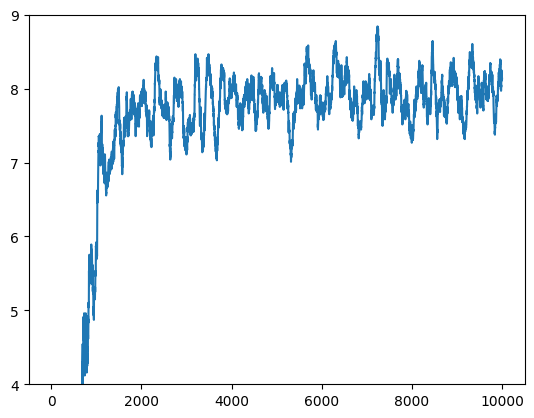

In [69]:
plt.plot(smoothed_rewards)
plt.ylim(4,9)